# Basic (binary) GP classification model


This notebook shows how to build a GP classification model using variational inference.
Here we consider binary (two-class, 0 vs. 1) classification only (there is a separate notebook on [multiclass classification](../advanced/multiclass_classification.ipynb)).
We first look at a one-dimensional example, and then show how you can adapt this when the input space is two-dimensional.

In [1]:
import numpy as np
import gpflow
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (8, 4)

## One-dimensional example

First of all, let's have a look at the data. `X` and `Y` denote the input and output values.
**NOTE:** `X` and `Y` must be two-dimensional NumPy arrays, $N \times 1$ or $N \times D$, where $D$ is the number of input dimensions/features, with the same number of rows as $N$ (one for each data point):

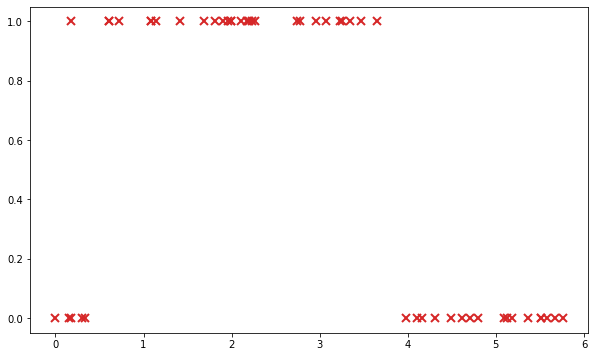

In [2]:
X = np.genfromtxt('data/classif_1D_X.csv').reshape(-1, 1)
Y = np.genfromtxt('data/classif_1D_Y.csv').reshape(-1, 1)

plt.figure(figsize=(10, 6))
plt.plot(X, Y, 'C3x', ms=8, mew=2);

### Reminders on GP classification

For a binary classification model using GPs, we can simply use a `Bernoulli` likelihood. The details of the generative model are as follows:

__1. Define the latent GP:__ we start from a Gaussian process $f \sim \mathcal{GP}(0, k(\cdot, \cdot'))$:

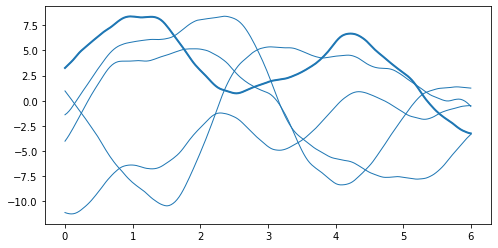

In [3]:
# build the kernel and covariance matrix
k = gpflow.kernels.Matern52(variance=20.)
x_grid = np.linspace(0, 6, 200).reshape(-1, 1)
K = k(x_grid)

# sample from a multivariate normal
rng = np.random.RandomState(6)

L = np.linalg.cholesky(K)
f_grid = np.dot(L, rng.randn(200, 5))
plt.plot(x_grid, f_grid, 'C0', linewidth=1)
plt.plot(x_grid, f_grid[:, 1], 'C0', linewidth=2);

__2. Squash them to $[0, 1]$:__ the samples of the GP are mapped to $[0, 1]$.
By default, GPflow uses the standard normal cumulative distribution function (inverse probit function): $p(x) = \Phi(f(x)) = \frac{1}{2} (1 + \operatorname{erf}(x / \sqrt{2}))$.
(This choice has the advantage that predictive mean, variance and density can be computed analytically, but any choice of invlink is possible, e.g. the logit $p(x) = \frac{\exp(f(x))}{1 + \exp(f(x))}$. Simply pass another function as the `invlink` argument to the `Bernoulli` likelihood class.)

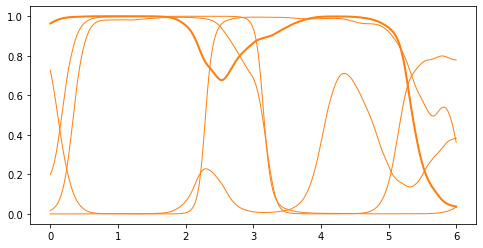

In [4]:
def invlink(f):
    return gpflow.likelihoods.Bernoulli().invlink(f).numpy()

p_grid = invlink(f_grid)
plt.plot(x_grid, p_grid, 'C1', linewidth=1)
plt.plot(x_grid, p_grid[:, 1], 'C1', linewidth=2);

__3. Sample from a Bernoulli:__ for each observation point $X_i$, the class label $Y_i \in \{0, 1\}$ is generated by sampling from a Bernoulli distribution $Y_i \sim \mathcal{B}(g(X_i))$.

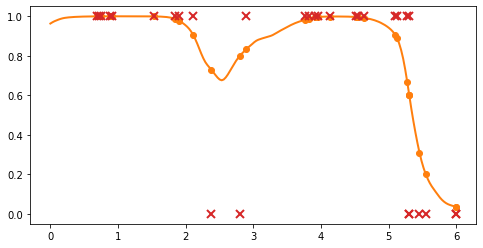

In [5]:
# Select some input locations
ind = rng.randint(0, 200, (30,))
X_gen = x_grid[ind]

# evaluate probability and get Bernoulli draws
p = p_grid[ind, 1:2]
Y_gen = rng.binomial(1, p)

# plot
plt.plot(x_grid, p_grid[:, 1], 'C1', linewidth=2)
plt.plot(X_gen, p, 'C1o', ms=6)
plt.plot(X_gen, Y_gen, 'C3x', ms=8, mew=2);

### Implementation with GPflow

For the model described above, the posterior $f(x)|Y$ (say $p$) is not Gaussian any more and does not have a closed-form expression.
A common approach is then to look for the best approximation of this posterior by a tractable distribution (say $q$) such as a Gaussian distribution.
In variational inference, the quality of an approximation is measured by the Kullback-Leibler divergence $\mathrm{KL}[q \| p]$.
For more details on this model, see Nickisch and Rasmussen (2008).

The inference problem is thus turned into an optimization problem: finding the best parameters for $q$.
In our case, we introduce $U \sim \mathcal{N}(q_\mu, q_\Sigma)$, and we choose $q$ to have the same distribution as $f | f(X) = U$.
The parameters $q_\mu$ and $q_\Sigma$ can be seen as parameters of $q$, which can be optimized in order to minimise  $\mathrm{KL}[q \| p]$.

This variational inference model is called `VGP` in GPflow:

In [6]:
m = gpflow.models.VGP((X, Y),
                      likelihood=gpflow.likelihoods.Bernoulli(),
                      kernel=gpflow.kernels.Matern52())

o = gpflow.optimizers.Scipy()

@tf.function()
def objective():
    return - m.log_marginal_likelihood()
o.minimize(objective, variables=m.trainable_variables)

      fun: 11.6786107781526
 hess_inv: <1327x1327 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.27949547e-05, -1.96361464e-05,  7.02257525e-05, ...,
       -6.38764945e-08, -1.58748234e-10, -5.16903427e-07])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 160
      nit: 156
   status: 0
  success: True
        x: array([ 1.41933531e+00,  3.29240817e+01, -1.11965074e+00, ...,
        7.28618770e-06,  4.66986009e-08,  9.99893867e-01])

We can now inspect the result of the optimization with `gpflow.utilities.print_summary(m)`:

In [7]:
gpflow.utilities.print_summary(m, fmt='notebook')

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,32.924081682397414
VGP.kernel.lengthscale,Parameter,Softplus,,True,(),float64,1.6359574325018242
VGP.q_mu,Parameter,,,True,"(50, 1)",float64,[[-1.11965074e+00...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 50, 50)",float64,"[[[4.55430257e-01, 0.00000000e+00, 0.00000000e+00..."


In this table, the first two lines are associated with the kernel parameters, and the last two correspond to the variational parameters.
**NOTE:** In practice, $q_\Sigma$ is actually parameterized by its lower-triangular square root $q_\Sigma = q_\text{sqrt} q_\text{sqrt}^T$ in order to ensure its positive-definiteness.

For more details on how to handle models in GPflow (getting and setting parameters, fixing some of them during optimization, using priors, and so on), see [Manipulating GPflow models](../understanding/models.ipynb).

### Predictions

Finally, we will see how to use model predictions to plot the resulting model.
We will replicate the figures of the generative model above, but using the approximate posterior distribution given by the model.

(-3, 3)

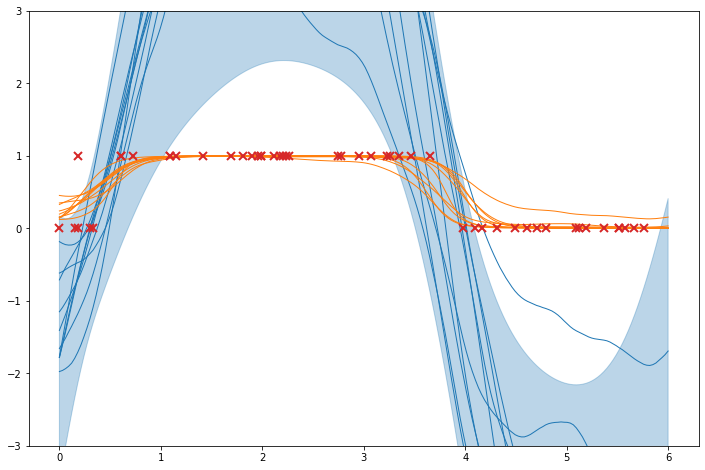

In [8]:
plt.figure(figsize=(12, 8))

# bubble fill the predictions
mu, var = m.predict_f(x_grid)

plt.fill_between(x_grid.flatten(),
                 np.ravel(mu + 2 * np.sqrt(var)),
                 np.ravel(mu - 2 * np.sqrt(var)),
                 alpha=0.3, color='C0')
    
# plot samples
tf.random.set_seed(6)
samples = m.predict_f_samples(x_grid, 10).numpy().squeeze().T

plt.plot(x_grid, samples, 'C0', lw=1)
    
# plot p-samples
p = invlink(samples)
plt.plot(x_grid, p, 'C1', lw=1)

# plot data
plt.plot(X, Y, 'C3x', ms=8, mew=2)
plt.ylim((-3,3))

## Two-dimensional example

In this section we will use the following data:

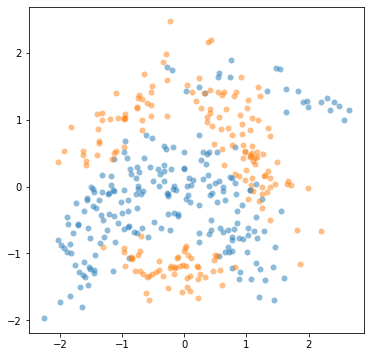

In [9]:
X = np.loadtxt('data/banana_X_train', delimiter=',')
Y = np.loadtxt('data/banana_Y_train', delimiter=',').reshape(-1,1)
mask = Y[:, 0]==1

plt.figure(figsize=(6, 6))
plt.plot(X[mask, 0], X[mask, 1], 'oC0', mew=0, alpha=0.5)
plt.plot(X[np.logical_not(mask), 0], X[np.logical_not(mask), 1], 'oC1', mew=0, alpha=0.5);

The model definition is the same as above; the only important difference is that we now specify that the kernel operates over a two-dimensional input space:

In [10]:
m = gpflow.models.VGP((X, Y),
                      kernel=gpflow.kernels.SquaredExponential(),
                      likelihood=gpflow.likelihoods.Bernoulli())

opt = gpflow.optimizers.Scipy()
@tf.function()
def objective():
    return - m.log_marginal_likelihood()
opt.minimize(objective,
             variables=m.trainable_variables,
             options=dict(maxiter=25), method='L-BFGS-B')  # TODO: make work with BFGS
# in practice, the optimization needs around 250 iterations to converge

      fun: 109.15371512187448
 hess_inv: <80602x80602 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.23786178e+00, -8.66976051e-01,  1.06489687e+00, ...,
        1.89913559e-07,  4.35090079e-06, -7.61766530e-06])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 27
      nit: 25
   status: 1
  success: False
        x: array([ 2.46208838e-03,  5.34079748e+00,  3.71326473e-01, ...,
       -5.61476059e-06, -1.87311247e-05,  9.99990748e-01])

We can now plot the predicted decision boundary between the two classes.
To do so, we can equivalently plot the contour lines $E[f(x)|Y]=0$, or $E[g(f(x))|Y]=0.5$.
We will do the latter, because it allows us to introduce the `predict_y` function, which returns the mean and variance at test points:

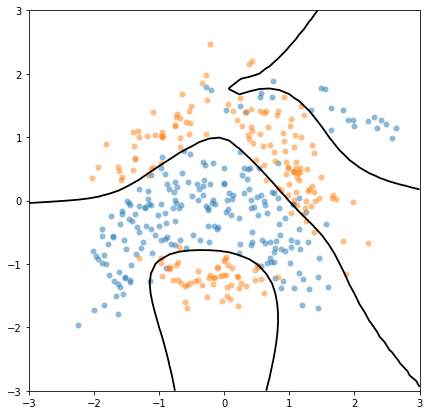

In [11]:
x_grid = np.linspace(-3, 3, 40)
xx, yy = np.meshgrid(x_grid, x_grid)
Xplot = np.vstack((xx.flatten(), yy.flatten())).T

p, _ = m.predict_y(Xplot)  # here we only care about the mean
plt.figure(figsize=(7, 7))
plt.plot(X[mask, 0], X[mask, 1], 'oC0', mew=0, alpha=0.5)
plt.plot(X[np.logical_not(mask), 0], X[np.logical_not(mask), 1], 'oC1', mew=0, alpha=0.5);

plt.contour(xx, yy, p.numpy().reshape(*xx.shape), [0.5],  # plot the p=0.5 contour line only
            colors='k', linewidths=1.8, zorder=100);

## Further reading

There are dedicated notebooks giving more details on how to manipulate [models](../understanding/models.ipynb) and [kernels](../advanced/kernels.ipynb).

This notebook covers only very basic classification models. You might also be interested in:
  * [Multiclass classification](../advanced/multiclass_classification.ipynb) if you have more than two classes.
  * [Sparse models](../advanced/gps_for_big_data.ipynb). The models above have one inducing variable $U_i$ per observation point $X_i$, which does not scale to large datasets.   Sparse Variational GP (SVGP) is an efficient alternative where the variables $U_i$ are defined at some inducing input locations $Z_i$ that can also be optimized.
  * [Exact inference](../advanced/mcmc.ipynb). We have seen that variational inference provides an approximation to the posterior. GPflow also supports exact inference using Markov Chain Monte Carlo (MCMC) methods, and the kernel parameters can also be assigned prior distributions in order to avoid point estimates.
  
## References

Hannes Nickisch and Carl Edward Rasmussen. 'Approximations for binary Gaussian process classification'. *Journal of Machine Learning Research* 9(Oct):2035--2078, 2008.